In [1]:
!pip install -U transformers bitsandbytes einops accelerate peft datasets wandb

## Load model in 4 bit

In [2]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, set_seed

# set seed
set_seed(42)

# Load model
modelpath = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_quant_type="nf4",
    ),
    torch_dtype=torch.float16,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load tokenizer

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast=False)    # fast tokenizer sometimes ignores the added tokens

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Add ChatML tokens to tokenizer and model, resize embeddings

In [4]:
# Add tokens <|im_start|> and <|im_end|>, latter is special eos token,
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))
model.config.eos_token_id = tokenizer.eos_token_id

## Prepare LoRA adapters

In [5]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules = [ "q_proj", "k_proj", "v_proj", "dense" ],
    lora_dropout=0.1,
    bias="none",
    modules_to_save = ["lm_head", "embed_tokens"],
    task_type="CAUSAL_LM"
)

# Add adapters to model
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)
model = get_peft_model(model, lora_config)
model.config.use_cache = False

# Load and preprocess dataset

In [6]:
from datasets import load_dataset

dataset = load_dataset("g-ronimo/riddles_evolved")
dataset = dataset["train"].train_test_split(test_size=0.1)


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['number', 'messages'],
        num_rows: 1513
    })
    test: Dataset({
        features: ['number', 'messages'],
        num_rows: 169
    })
})

In [8]:
dataset["train"][0]

{'number': 1509,
 'messages': ["What starts with a 'C' is covered with keys, but we use only one. What is it?",
  'The answer to the riddle is a "coconut." While a coconut is covered with many small "keys" or eyes, we typically open it with just one tool, such as a coconut crusher or a large nail.',
  "Cool, so what's that thing we eat that looks like a big brown ball and has lots of little bumps on it, but we only use one thing to open it? I guess it's not a basketball?",
  'I believe you\'re referring to an artichoke. While an artichoke looks like a large brown ball with small bumps on it, we typically use a tool called a "dip tool" or a "lemon tool" with a sharp tip or a pair of scissors to remove the small, sharp thorns covering the artichoke\'s bracts, allowing us to eat the tender heart inside.']}

## Apply ChatML format and tokenize

In [9]:
import os
from functools import partial

# Format (chatML) and tokenize dataset
templates=[
    "<|im_start|>assistant\n{msg}<|im_end|>",
    "<|im_start|>user\n{msg}<|im_end|>"
]
IGNORE_INDEX=-100

def tokenize(input, max_length):
    input_ids, attention_mask, labels = [], [], []

    for i,msg in enumerate(input["messages"]):
        isHuman = i%2==0
        msg_chatml=templates[isHuman].format(msg=msg)
        msg_tokenized=tokenizer(msg_chatml, truncation=False, add_special_tokens=False)

        input_ids+=msg_tokenized["input_ids"]
        attention_mask+=msg_tokenized["attention_mask"]
        labels+=[IGNORE_INDEX]*len(msg_tokenized["input_ids"]) if isHuman else msg_tokenized["input_ids"]

    return {
        "input_ids": input_ids[:max_length],
        "attention_mask": attention_mask[:max_length],
        "labels": labels[:max_length],
    }

dataset_tokenized = dataset.map(
    partial(tokenize, max_length=512),
    batched=False,
    num_proc=os.cpu_count(),    # multithreaded
    remove_columns=dataset["train"].column_names  # don't need this anymore, we have tokens from here on
)

longest sample: 512 tokens


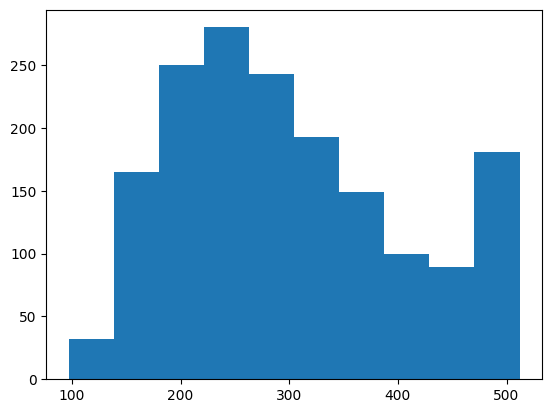

In [10]:
# Sample size distribution
import matplotlib.pyplot as plt

data = [len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])]
print(f"longest sample: {max(data)} tokens")

plt.hist(data, bins=10)
plt.show()

## Define a collate function, train on answers only

In [11]:
# collate function - to transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_ids: [..], labels: [..], attention_mask: [..] }
def collate(elements):
    tokens=[e["input_ids"] for e in elements]
    tokens_maxlen=max([len(t) for t in tokens])

    for i,sample in enumerate(elements):
        input_ids=sample["input_ids"]
        labels=sample["labels"]
        attention_mask=sample["attention_mask"]

        pad_len=tokens_maxlen-len(input_ids)

        input_ids.extend( pad_len * [tokenizer.pad_token_id] )
        labels.extend( pad_len * [IGNORE_INDEX] )
        attention_mask.extend( pad_len * [0] )

    batch={
        "input_ids": torch.tensor( [e["input_ids"] for e in elements] ),
        "labels": torch.tensor( [e["labels"] for e in elements] ),
        "attention_mask": torch.tensor( [e["attention_mask"] for e in elements] ),
    }

    return batch


# Train

## Set hyperparameters

In [12]:
from transformers import TrainingArguments, Trainer

bs=1     # batch size
eval_bs=4     # eval. batch size
ga_steps=16  # gradient acc. steps
epochs=20
lr=0.00002

steps_per_epoch=len(dataset_tokenized["train"])//(bs*ga_steps)

args = TrainingArguments(
    output_dir="out",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=eval_bs,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,
    save_steps=steps_per_epoch,
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",      # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=False,
    fp16=True,
    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
)



## Start training

In [15]:
trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 